In [1]:
import glob
import os
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials import align_trials, select_trials
import pandas as pd
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
seed = 1997

In [2]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [15]:
def get_selectivity_info(neu:NeuronData):

    res = {}
    res["nid"] = neu.get_neuron_id()

    samples = [11, 15, 51, 55, 0]
    for inout in ['in','out']:
        mask = getattr(neu,'mask_'+inout)
        sp = getattr(neu,'sample_on_'+inout)
        sp = firing_rate.moving_average(data=sp, win=100, step=1)[:, 300:]
        sample_id = neu.sample_id[mask]
        sp_samples = select_trials.get_sp_by_sample(sp, sample_id, samples)
        o1 = np.concatenate((sp_samples["11"], sp_samples["15"]))
        o5 = np.concatenate((sp_samples["51"], sp_samples["55"]))
        c1 = np.concatenate((sp_samples["11"], sp_samples["51"]))
        c5 = np.concatenate((sp_samples["15"], sp_samples["55"]))
        sample = np.concatenate(
            (sp_samples["11"], sp_samples["15"], sp_samples["51"], sp_samples["55"])
        )
        n0 = sp_samples["0"]
        # Check selectivity and latency
        color_lat, color_score = smetrics.get_selectivity(c1, c5, win=75,scores=True)
        color_selec = "nan" if np.isnan(color_lat) else "c1" if color_score[color_lat] > 0 else "c5"
        orient_lat, orient_score = smetrics.get_selectivity(o1, o5, win=75,scores=True)
        orient_selec =  "nan" if np.isnan(orient_lat) else "o1" if orient_score[orient_lat] > 0 else "o5" 
        neutral_lat, neutral_score = smetrics.get_selectivity(sample, n0, win=75,scores=True)
        neutral_selec = "nan" if np.isnan(neutral_lat) else "NN" if neutral_score[neutral_lat] > 0 else "N" 
        
        res["color_lat_" + inout] = color_lat
        res["color_selec_" + inout] = color_selec
        res["color_score_" + inout] = color_score
        res["orient_lat_" + inout] = orient_lat
        res["orient_selec_" + inout] = orient_selec
        res["orient_score_" + inout] = orient_score
        res["neutral_lat_" + inout] = neutral_lat
        res["neutral_selec_" + inout] = neutral_selec
        res["neutral_score_" + inout] = neutral_score

    return res

In [4]:
def get_neu_align (path,params,sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
                select_block=it["select_block"],
                select_pos=it["inout"],
                event=it["event"],
                time_before=it["time_before"],
                error_type=0,
            )
        endt=it['time_before']+it['end']
        stt=it['time_before']+it['st']
        setattr(neu, it['sp'], np.array(sp[:,:endt],dtype=it["dtype_sp"]))
        setattr(neu, it['mask'], np.array(mask,dtype=it["dtype_mask"]))
    
    if ~sp_sample: setattr(neu, 'sp_samples', np.array([]))

    return neu

In [6]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}

for area in areas:
    print(area)
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)

lip


In [7]:
params =[{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},
         {'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}]

In [8]:
population = Parallel(n_jobs=-1)(
    delayed(get_neu_align)(neu,params) for neu in tqdm(path_list)
)

  9%|▉         | 48/530 [00:14<02:03,  3.91it/s]

KeyboardInterrupt: 

In [ ]:
comment = "{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},{'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':500,'st':0,'end':1000,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}"

In [30]:
population = PopulationData(population, comment=comment)

In [31]:
population.to_python_hdf5('test2.h5')

In [9]:
popu=PopulationData.from_python_hdf5('test2.h5')

In [10]:
popu.population[0].__dict__.keys()

dict_keys(['date_time', 'subject', 'area', 'experiment', 'recording', 'sp_samples', 'cluster_id', 'cluster_ch', 'cluster_group', 'cluster_number', 'cluster_array_pos', 'cluster_depth', 'block', 'trial_error', 'code_samples', 'code_numbers', 'position', 'pos_code', 'sample_id', 'test_stimuli', 'test_distractor', 'mask_in', 'mask_out', 'sample_on_in', 'sample_on_out'])

In [16]:
get_selectivity_info(popu.population[30])

{'nid': 'mua3LIP2023-02-08_10-39-41Riesling',
 'color_lat_in': nan,
 'color_selec_in': 'nan',
 'color_score_in': nan,
 'orient_lat_in': 336,
 'orient_selec_in': 'o1',
 'orient_score_in': array([-0.08, -0.06, -0.08, ...,  0.24,  0.22,  0.  ]),
 'neutral_lat_in': 438,
 'neutral_selec_in': 'NN',
 'neutral_score_in': array([0.08, 0.08, 0.06, ..., 0.26, 0.26, 0.  ]),
 'color_lat_out': nan,
 'color_selec_out': 'nan',
 'color_score_out': nan,
 'orient_lat_out': 630,
 'orient_selec_out': 'o1',
 'orient_score_out': array([0.08, 0.08, 0.08, ..., 0.08, 0.06, 0.  ]),
 'neutral_lat_out': 344,
 'neutral_selec_out': 'NN',
 'neutral_score_out': array([-0.04, -0.04, -0.04, ..., -0.06, -0.08,  0.  ])}

In [17]:
df_selectivity = popu.execute_function(get_selectivity_info, n_jobs=-1, ret_df=True)


In [36]:
df_selectivity=df_selectivity.replace('nan',np.nan)
df_selectivity.to_csv("population_selectivity_" + area + ".csv", index=False)

In [37]:
df_fr=pd.read_csv('C:/Users/camil/Documents/int/code/Users/losadac/data_stats/neurons/population_fr_lip.csv')#.drop('Unnamed: 0', axis=1) 
df_selectivity=pd.read_csv("population_selectivity_" + area + ".csv")

In [40]:
df_sel1=pd.merge(df_selectivity, df_fr, left_on='nid',right_on='nid')
df_sel_in=df_sel1[df_sel1['fr_sampleNNin']>=1]
df_sel_out=df_sel1[df_sel1['fr_sampleNNout']>=1]

Text(0.5, 1.0, 'orient_lat_out')

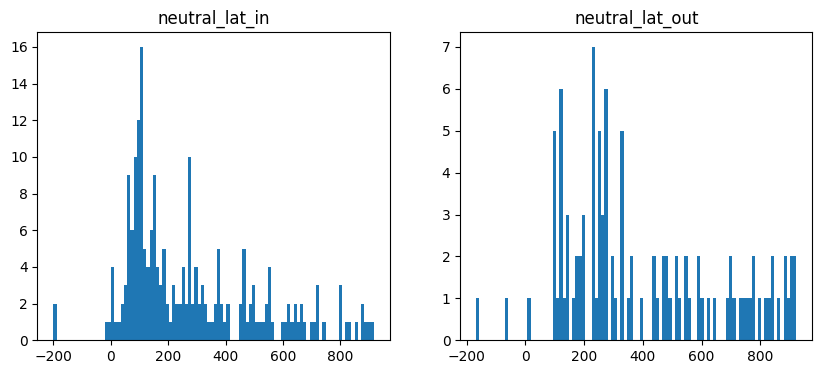

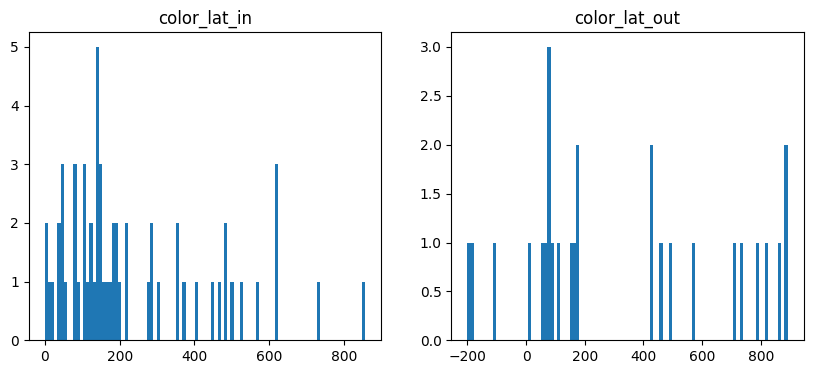

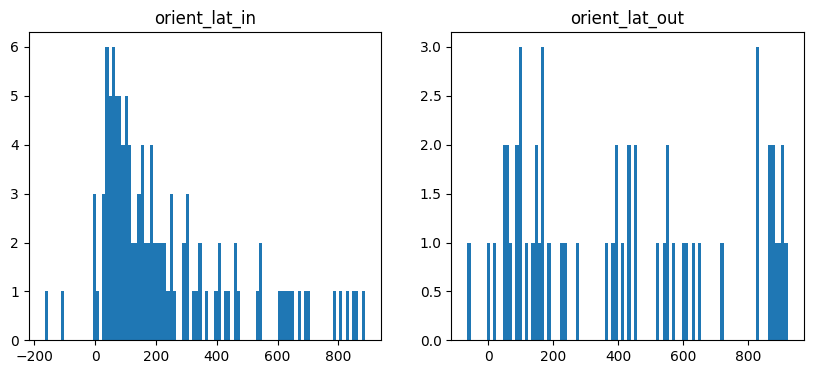

In [43]:
f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_lat_in']-200,bins=100) 
ax[0].set_title('neutral_lat_in')
ax[1].hist(df_sel_out[df_sel_out['neutral_lat_out'].notna()]['neutral_lat_out']-200,bins=100) 
ax[1].set_title('neutral_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['color_lat_in'].notna()]['color_lat_in']-200,bins=100) 
ax[0].set_title('color_lat_in')
ax[1].hist(df_sel_out[df_sel_out['color_lat_out'].notna()]['color_lat_out']-200,bins=100) 
ax[1].set_title('color_lat_out')

f,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df_sel_in[df_sel_in['orient_lat_in'].notna()]['orient_lat_in']-200,bins=100) 
ax[0].set_title('orient_lat_in')
ax[1].hist(df_sel_out[df_sel_out['orient_lat_out'].notna()]['orient_lat_out']-200,bins=100) 
ax[1].set_title('orient_lat_out')